In [4]:
%matplotlib inline

In [10]:
import talib as ta

In [5]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

class Indicators:
    
    def RSI(self,p,lb,feature_dict):
        # RSI technical indicator.
        # p, the series having its RSI computed.
        # lb, the lookback period, does not need to be integer.
        #     typical values in the range of 1.5 to 5.0.
        # Return is a numpy array with values in the range 0.0 to 1.0.
        nrows = p.shape[0]
        print (nrows)
        lam = 2.0 / (lb + 1.0)
        UpMove = np.zeros(nrows)
        DnMove = np.zeros(nrows)
        UpMoveSm = np.zeros(nrows)
        DnMoveSm = np.zeros(nrows)
        Numer = np.zeros(nrows)
        Denom = np.zeros(nrows)
        pChg = np.zeros(nrows)
        RSISeries = np.zeros(nrows)
        # Compute pChg in points using a loop.
        for i in range (1,nrows):
            pChg[i] = p[i] - p[i-1]    
        # Compute pChg as a percentage using a built-in method.
        #    pChg = p.pct_change()
        UpMove = np.where(pChg>0,pChg,0)
        DnMove = np.where(pChg<0,-pChg,0)
        
        for i in range(1,nrows):
            UpMoveSm[i] = lam*UpMove[i] + (1.0-lam)*UpMoveSm[i-1]
            DnMoveSm[i] = lam*DnMove[i] + (1.0-lam)*DnMoveSm[i-1]
            Numer[i] = UpMoveSm[i]
            Denom[i] = UpMoveSm[i] + DnMoveSm[i]
            if Denom[i] <= 0:
                RSISeries[i] = 0.5
            else:
                RSISeries[i] =  Numer[i]/Denom[i]
        feature_dict['RSI_' + str(lb)] = 'Keep'
        return RSISeries, feature_dict
    
    def DPO(self,p,lb,feature_dict):
        # Detrended price oscillator. 
        # A high pass filter.
        # p, the series being transformed.
        # lb, the lookback period, a real number.
        # Uses pandas ewma function.
        # Return is a numpy array with values centered on 0.0.
        nrows = p.shape[0]
        #ma = pd.ewma(p,span=lb)
        ma = p.ewm(span=lb,min_periods=0,adjust=True,ignore_na=False).mean()
        d = np.zeros(nrows)
        for i in range(1,nrows):
            d[i] = (p[i]-ma[i])/ma[i]
        feature_dict['DPO_' + str(lb)] = 'Keep'
        return d, feature_dict
    
    def ROC(self,p,lb,feature_dict):
        # Rate of change technical indicator.
        # p, the series having its ROC computed.
        # lb, the lookback period.  Typically 1.
        # Return is a numpy array with values as decimal fractions.
        # A 1% change is 0.01.
        nrows = p.shape[0]
        r = np.zeros(nrows)
        for i in range(lb, nrows):
            r[i] = (p[i]-p[i-lb])/p[i-lb]
        feature_dict['ROC_'+ str(lb)] = 'Keep'
        return r, feature_dict
    
    
    def ATR(self,ph,pl,pc,lb,feature_dict):
        # Average True Range technical indicator.
        # ph, pl, pc are the series high, low, and close.
        # lb, the lookback period.  An integer number of bars.
        # True range is computed as a fraction of the closing price.
        # Return is a numpy array of floating point values.
        # Values are non-negative, with a minimum of 0.0.
        # An ATR of 5 points on a issue closing at 50 is
        #    reported as 0.10. 
        nrows = pc.shape[0]
        th = np.zeros(nrows)
        tl = np.zeros(nrows)
        tc = np.zeros(nrows)
        tr = np.zeros(nrows)
        trAvg = np.zeros(nrows)
        
        for i in range(1,nrows):
            if ph[i] > pc[i-1]:
                th[i] = ph[i]
            else:
                th[i] = pc[i-1]
            if pl[i] < pc[i-1]:
                tl[i] = pl[i]
            else:
                tl[i] = pc[i-1]
            tr[i] = th[i] - tl[i]
        for i in range(lb,nrows):
            trAvg[i] = tr[i]            
            for j in range(1,lb-1):
                trAvg[i] = trAvg[i] + tr[i-j]
            trAvg[i] = trAvg[i] / lb
            trAvg[i] = trAvg[i] / pc[i]   
        feature_dict['ATR_'+ str(lb)] = 'Keep'
        return trAvg, feature_dict
    
    def add_indicators(self,df, ind_list, feature_dict):
        #loop through ind_list
        indDataSet = df
        i = 0
        for i in ind_list:
            print(i)
            sel_ind = i[0]
            if sel_ind == 'RSI':
                indDataSet['RSI'],feature_dict = self.RSI(indDataSet.Pri, i[1], feature_dict)
            elif sel_ind == 'DPO':
                indDataSet['DPO'],feature_dict = self.DPO(indDataSet.Pri, i[1], feature_dict)
            elif sel_ind == 'ROC':
                indDataSet['ROC'],feature_dict = self.ROC(indDataSet.Pri, i[1], feature_dict)
            elif sel_ind == 'ATR':
                indDataSet['ATR'],feature_dict = self.ATR(indDataSet.High, indDataSet.Low, indDataSet.Pri, i[1], feature_dict)
            else:
                continue
        return indDataSet, feature_dict

Successfully retrieved data series for TLT


(<Figure size 720x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xa050278>)

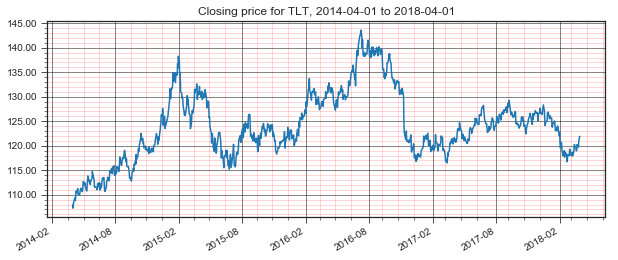

In [7]:
import sys
sys.path.append('./lib')
sys.path.append('./utilities')
from plot_utils import *
from retrieve_data import *
dataLoadStartDate = "2014-04-01"
dataLoadEndDate = "2018-04-01"
issue = "TLT"
feature_dict = {}
    
dSet = DataRetrieve()
dataSet = dSet.read_issue_data(issue)
    
dataSet = dSet.set_date_range(dataSet, dataLoadStartDate,dataLoadEndDate)
    
plotIt = PlotUtility()
    
plotTitle = "Closing price for " + issue + ", " + str(dataLoadStartDate) + " to " + str(dataLoadEndDate)
plotIt.plot_v1(dataSet['Pri'], plotTitle)

In [8]:
addIndic1 = Indicators()
ind_list = [("RSI", 2.3),("ROC",5),("DPO",5),("ATR", 5)]
dataSet, feature_dict = addIndic1.add_indicators(dataSet, ind_list, feature_dict)

('RSI', 2.3)
1004
('ROC', 5)
('DPO', 5)
('ATR', 5)


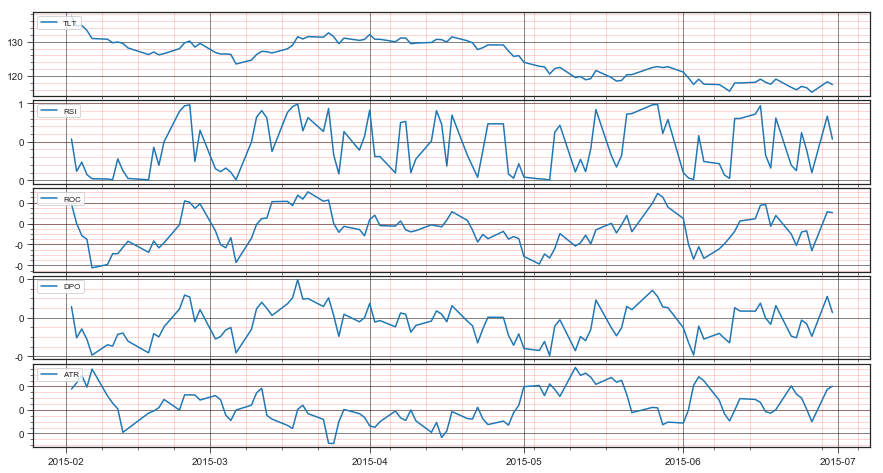

In [23]:
startDate = "2015-02-01"
endDate = "2015-06-30"
rsiDataSet = dataSet.ix[startDate:endDate]
#fig = plt.figure(figsize=(15,8  ))
fig, axes = plt.subplots(5,1, figsize=(15,8), sharex=True)
plt.subplots_adjust(hspace=0.05)
axes[0].plot(rsiDataSet['Pri'], label=issue)
axes[1].plot(rsiDataSet['RSI'], label='RSI');
axes[2].plot(rsiDataSet['ROC'], label='ROC');
axes[3].plot(rsiDataSet['DPO'], label='DPO');
axes[4].plot(rsiDataSet['ATR'], label='ATR');

for ax in axes:
                ax.label_outer()
                ax.legend(loc='upper left', frameon=True, fontsize=8)
                ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
                ax.grid(True, which='both')
                ax.xaxis_date()
                ax.autoscale_view()
                ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.6)
                ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
                ax.minorticks_on()

In [15]:
dataSet['10dSMA'] = ta.SMA(dataSet.Pri.values)
dataSet['10dEMA'] = ta.EMA(dataSet.Pri.values)

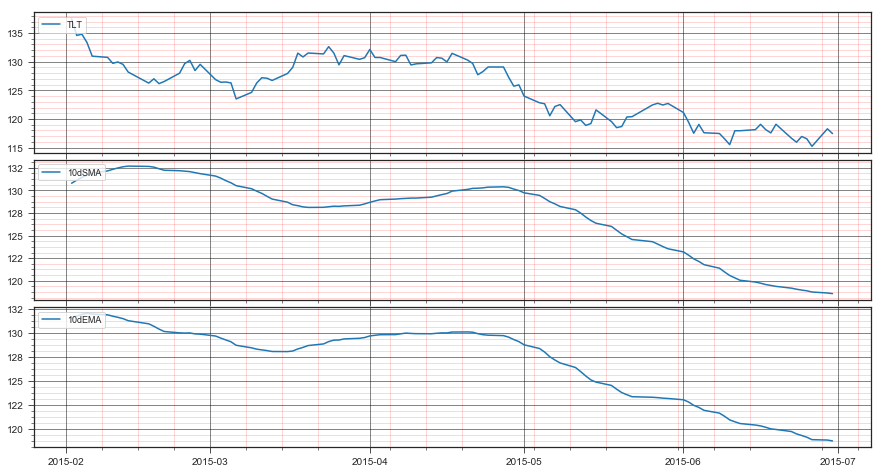

In [22]:
startDate = "2015-02-01"
endDate = "2015-06-30"
rsiDataSet = dataSet.ix[startDate:endDate]
fig, axes = plt.subplots(3,1, figsize=(15,8), sharex=True)
plt.subplots_adjust(hspace=0.05)
axes[0].plot(rsiDataSet['Pri'], label=issue)
axes[1].plot(rsiDataSet['10dSMA'], label='10dSMA');
axes[2].plot(rsiDataSet['10dEMA'], label='10dEMA');
for ax in axes:
                ax.label_outer()
                ax.legend(loc='upper left', frameon=True, fontsize=9)
                ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
                ax.grid(True, which='both')
                ax.xaxis_date()
                ax.autoscale_view()
                ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.6)
                ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
                ax.minorticks_on()